In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 14
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 16


In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False,kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False,kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 32)   4704        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 32)   128         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 32)     9216        spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 32)     128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 32)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 32)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 32)           0           spatial_dropout2d_9[0][0]        
__________

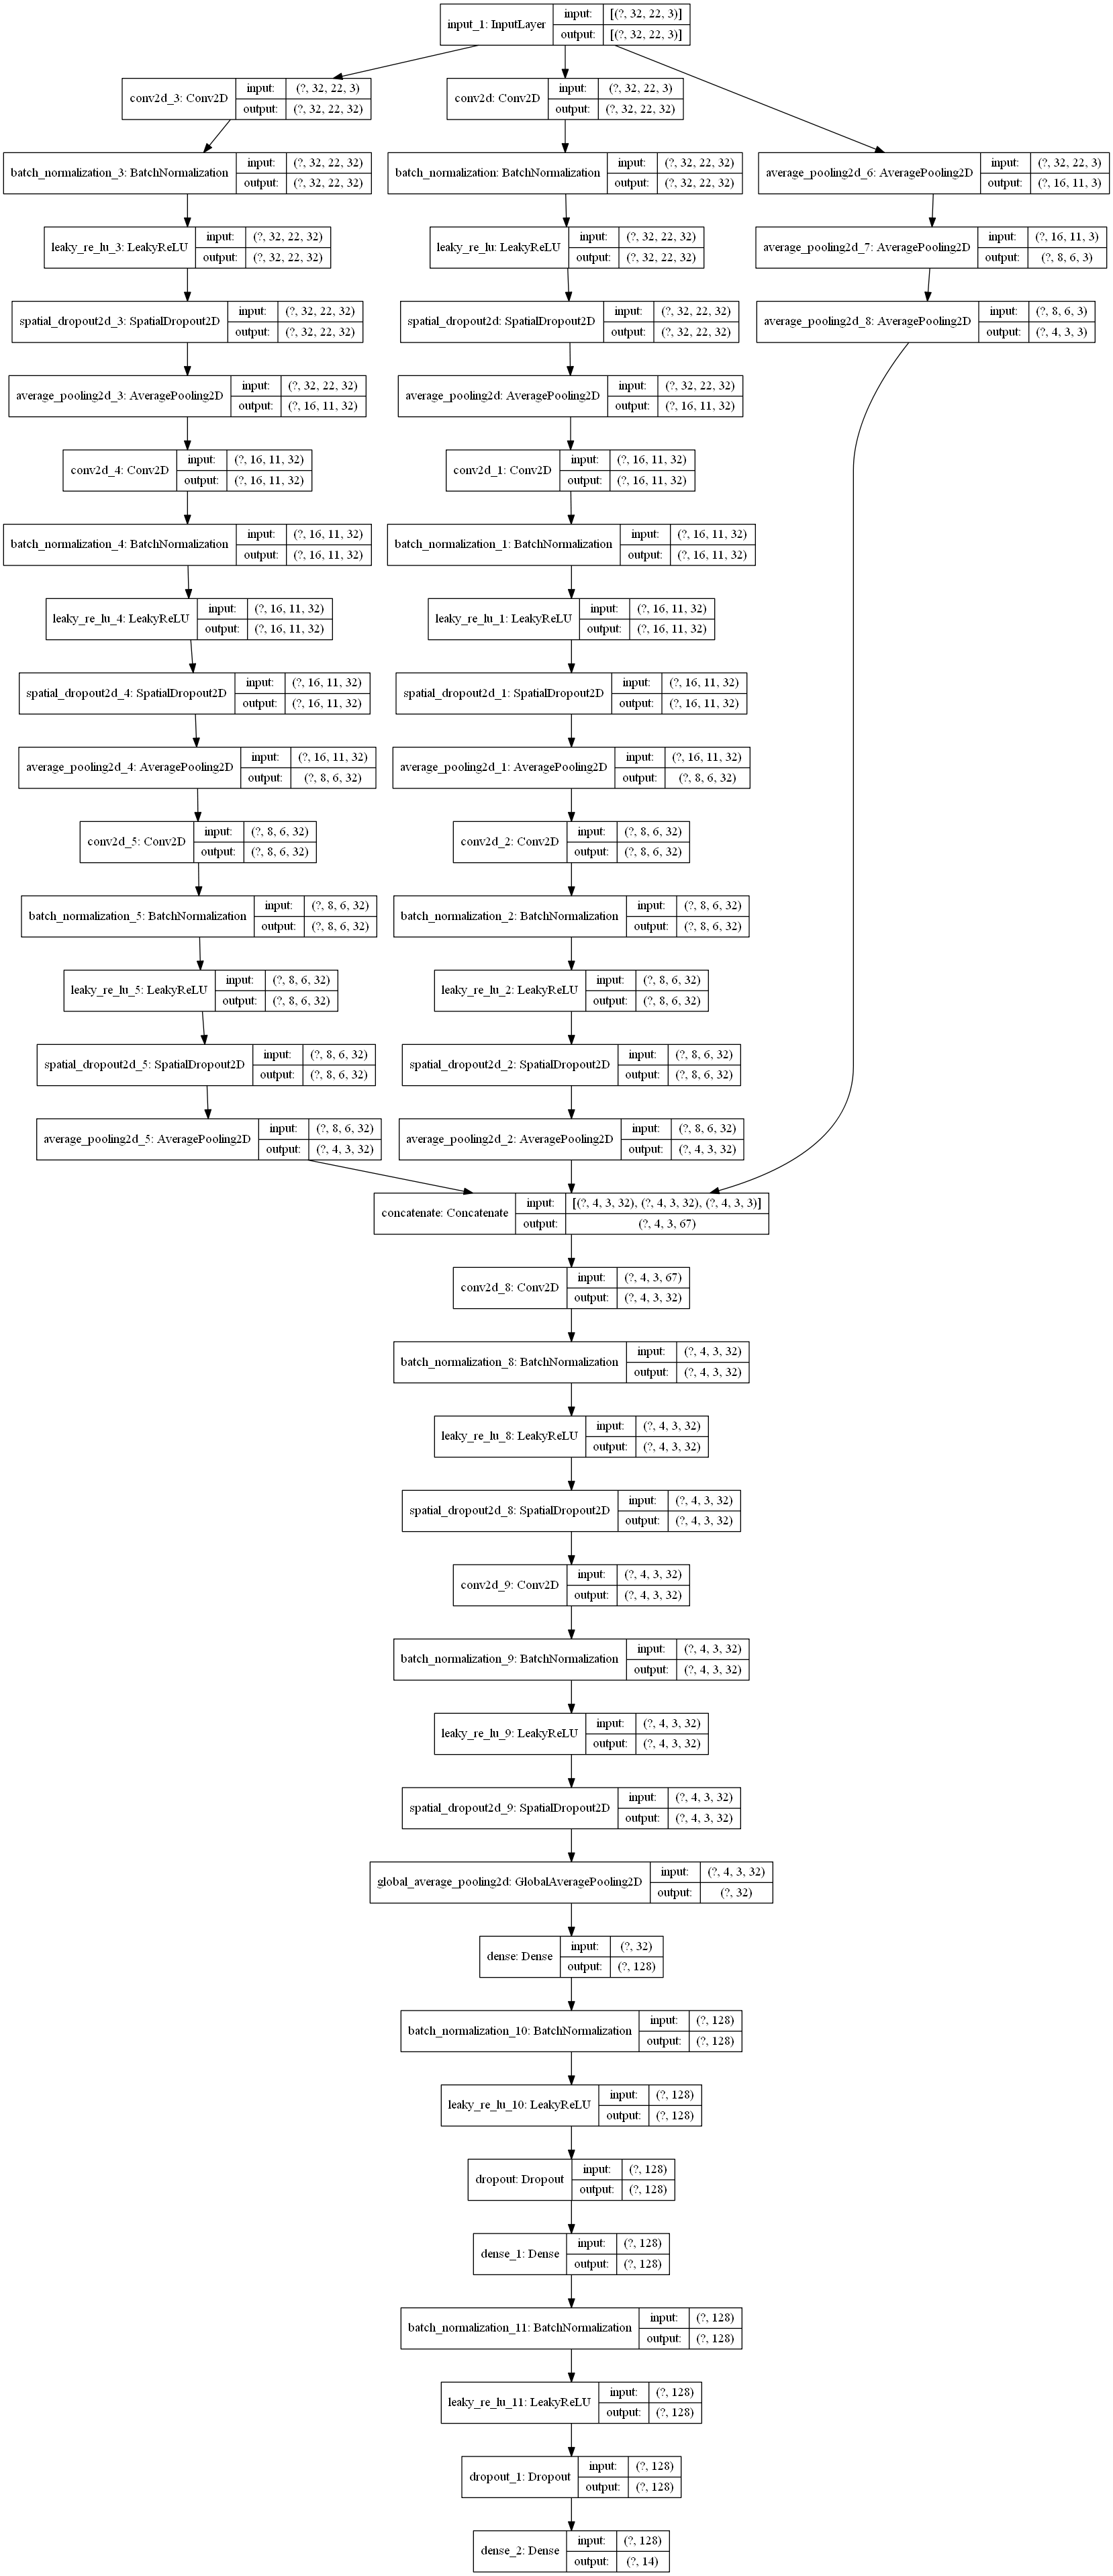

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  2%|█▌                                                                             | 40/1960 [00:00<00:09, 194.13it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 198.19it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 197.94it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:34 - loss: 3.3428 - acc: 0.031 - ETA: 48s - loss: 3.1472 - acc: 0.078 - ETA: 32s - loss: 2.9444 - acc: 0.10 - ETA: 24s - loss: 2.8519 - acc: 0.11 - ETA: 20s - loss: 2.7998 - acc: 0.11 - ETA: 17s - loss: 2.7174 - acc: 0.12 - ETA: 14s - loss: 2.6692 - acc: 0.13 - ETA: 13s - loss: 2.6487 - acc: 0.14 - ETA: 11s - loss: 2.6192 - acc: 0.15 - ETA: 10s - loss: 2.5668 - acc: 0.17 - ETA: 9s - loss: 2.5345 - acc: 0.1761 - ETA: 9s - loss: 2.5079 - acc: 0.171 - ETA: 8s - loss: 2.4610 - acc: 0.180 - ETA: 7s - loss: 2.4297 - acc: 0.183 - ETA: 7s - loss: 2.4134 - acc: 0.183 - ETA: 6s - loss: 2.3860 - acc: 0.191 - ETA: 6s - loss: 2.3511 - acc: 0.204 - ETA: 6s - loss: 2.3244 - acc: 0.208 - ETA: 5s - loss: 2.2929 - acc: 0.225 - ETA: 5s - loss: 2.2745 - acc: 0.231 - ETA: 5s - loss: 2.2500 - acc: 0.244 - ETA: 4s - loss: 2.2368 - acc: 0.248 - ETA: 4s - loss: 2.2142 - acc: 0.254 - ETA: 4s - loss: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.6874 - acc: 0.781 - ETA: 3s - loss: 0.5408 - acc: 0.843 - ETA: 3s - loss: 0.6590 - acc: 0.791 - ETA: 3s - loss: 0.6106 - acc: 0.804 - ETA: 3s - loss: 0.6062 - acc: 0.800 - ETA: 3s - loss: 0.6104 - acc: 0.807 - ETA: 3s - loss: 0.6027 - acc: 0.821 - ETA: 3s - loss: 0.6312 - acc: 0.808 - ETA: 2s - loss: 0.6276 - acc: 0.809 - ETA: 2s - loss: 0.5978 - acc: 0.815 - ETA: 2s - loss: 0.5904 - acc: 0.818 - ETA: 2s - loss: 0.6162 - acc: 0.807 - ETA: 2s - loss: 0.6289 - acc: 0.805 - ETA: 2s - loss: 0.6151 - acc: 0.810 - ETA: 2s - loss: 0.6016 - acc: 0.814 - ETA: 2s - loss: 0.5934 - acc: 0.816 - ETA: 2s - loss: 0.5994 - acc: 0.814 - ETA: 2s - loss: 0.6013 - acc: 0.812 - ETA: 2s - loss: 0.5900 - acc: 0.817 - ETA: 2s - loss: 0.5933 - acc: 0.814 - ETA: 2s - loss: 0.5860 - acc: 0.819 - ETA: 2s - loss: 0.5870 - acc: 0.819 - ETA: 2s - loss: 0.5795 - acc: 0.822 - ETA: 2s - loss: 0.5945 - acc: 0.816 - ETA: 2s - loss: 0.5909 - acc: 0.817 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.3128 - acc: 0.937 - ETA: 4s - loss: 0.3552 - acc: 0.875 - ETA: 3s - loss: 0.4329 - acc: 0.843 - ETA: 3s - loss: 0.4060 - acc: 0.851 - ETA: 3s - loss: 0.4454 - acc: 0.850 - ETA: 3s - loss: 0.4472 - acc: 0.849 - ETA: 3s - loss: 0.4949 - acc: 0.839 - ETA: 3s - loss: 0.5459 - acc: 0.832 - ETA: 3s - loss: 0.5204 - acc: 0.836 - ETA: 2s - loss: 0.5055 - acc: 0.843 - ETA: 2s - loss: 0.5061 - acc: 0.840 - ETA: 2s - loss: 0.4966 - acc: 0.841 - ETA: 2s - loss: 0.4893 - acc: 0.841 - ETA: 2s - loss: 0.5265 - acc: 0.825 - ETA: 2s - loss: 0.5124 - acc: 0.829 - ETA: 2s - loss: 0.5117 - acc: 0.828 - ETA: 2s - loss: 0.5089 - acc: 0.825 - ETA: 2s - loss: 0.4921 - acc: 0.833 - ETA: 2s - loss: 0.4907 - acc: 0.832 - ETA: 2s - loss: 0.5027 - acc: 0.829 - ETA: 2s - loss: 0.4950 - acc: 0.831 - ETA: 2s - loss: 0.5001 - acc: 0.828 - ETA: 2s - loss: 0.4991 - acc: 0.827 - ETA: 2s - loss: 0.4944 - acc: 0.829 - ETA: 2s - loss: 0.4829 - acc: 0.833 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.3177 - acc: 0.875 - ETA: 3s - loss: 0.2532 - acc: 0.890 - ETA: 3s - loss: 0.3002 - acc: 0.885 - ETA: 3s - loss: 0.3039 - acc: 0.898 - ETA: 3s - loss: 0.2866 - acc: 0.900 - ETA: 3s - loss: 0.2930 - acc: 0.906 - ETA: 3s - loss: 0.3004 - acc: 0.897 - ETA: 3s - loss: 0.2946 - acc: 0.898 - ETA: 2s - loss: 0.3024 - acc: 0.902 - ETA: 2s - loss: 0.3152 - acc: 0.893 - ETA: 2s - loss: 0.3222 - acc: 0.894 - ETA: 2s - loss: 0.3186 - acc: 0.898 - ETA: 2s - loss: 0.3400 - acc: 0.889 - ETA: 2s - loss: 0.3423 - acc: 0.888 - ETA: 2s - loss: 0.3678 - acc: 0.883 - ETA: 2s - loss: 0.3871 - acc: 0.878 - ETA: 2s - loss: 0.3774 - acc: 0.880 - ETA: 2s - loss: 0.3765 - acc: 0.883 - ETA: 2s - loss: 0.3765 - acc: 0.884 - ETA: 2s - loss: 0.3760 - acc: 0.882 - ETA: 2s - loss: 0.3833 - acc: 0.876 - ETA: 2s - loss: 0.3818 - acc: 0.879 - ETA: 2s - loss: 0.3749 - acc: 0.880 - ETA: 2s - loss: 0.3698 - acc: 0.884 - ETA: 2s - loss: 0.3778 - acc: 0.882 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2189 - acc: 0.968 - ETA: 3s - loss: 0.2296 - acc: 0.937 - ETA: 3s - loss: 0.2165 - acc: 0.937 - ETA: 3s - loss: 0.2601 - acc: 0.929 - ETA: 3s - loss: 0.2422 - acc: 0.937 - ETA: 3s - loss: 0.2542 - acc: 0.927 - ETA: 2s - loss: 0.2833 - acc: 0.919 - ETA: 2s - loss: 0.2868 - acc: 0.921 - ETA: 2s - loss: 0.3014 - acc: 0.913 - ETA: 2s - loss: 0.3029 - acc: 0.912 - ETA: 2s - loss: 0.3025 - acc: 0.911 - ETA: 2s - loss: 0.3314 - acc: 0.914 - ETA: 2s - loss: 0.3291 - acc: 0.913 - ETA: 2s - loss: 0.3201 - acc: 0.917 - ETA: 2s - loss: 0.3317 - acc: 0.916 - ETA: 2s - loss: 0.3254 - acc: 0.918 - ETA: 2s - loss: 0.3182 - acc: 0.917 - ETA: 2s - loss: 0.3198 - acc: 0.916 - ETA: 2s - loss: 0.3181 - acc: 0.911 - ETA: 2s - loss: 0.3114 - acc: 0.914 - ETA: 2s - loss: 0.3229 - acc: 0.909 - ETA: 2s - loss: 0.3139 - acc: 0.911 - ETA: 2s - loss: 0.3071 - acc: 0.914 - ETA: 2s - loss: 0.3019 - acc: 0.916 - ETA: 2s - loss: 0.3067 - acc: 0.916 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2274 - acc: 0.968 - ETA: 3s - loss: 0.2079 - acc: 0.968 - ETA: 3s - loss: 0.1914 - acc: 0.968 - ETA: 3s - loss: 0.2385 - acc: 0.945 - ETA: 3s - loss: 0.2656 - acc: 0.925 - ETA: 3s - loss: 0.2534 - acc: 0.921 - ETA: 2s - loss: 0.2620 - acc: 0.910 - ETA: 2s - loss: 0.2519 - acc: 0.914 - ETA: 2s - loss: 0.2418 - acc: 0.920 - ETA: 2s - loss: 0.2548 - acc: 0.918 - ETA: 2s - loss: 0.2490 - acc: 0.920 - ETA: 2s - loss: 0.2559 - acc: 0.919 - ETA: 2s - loss: 0.2798 - acc: 0.913 - ETA: 2s - loss: 0.2842 - acc: 0.908 - ETA: 2s - loss: 0.2878 - acc: 0.906 - ETA: 2s - loss: 0.3033 - acc: 0.902 - ETA: 2s - loss: 0.3129 - acc: 0.900 - ETA: 2s - loss: 0.3169 - acc: 0.901 - ETA: 2s - loss: 0.3095 - acc: 0.903 - ETA: 2s - loss: 0.3141 - acc: 0.903 - ETA: 2s - loss: 0.3028 - acc: 0.907 - ETA: 2s - loss: 0.3003 - acc: 0.907 - ETA: 2s - loss: 0.3016 - acc: 0.903 - ETA: 2s - loss: 0.2984 - acc: 0.904 - ETA: 2s - loss: 0.2935 - acc: 0.906 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1148 - acc: 1.000 - ETA: 3s - loss: 0.1686 - acc: 0.968 - ETA: 3s - loss: 0.2357 - acc: 0.947 - ETA: 3s - loss: 0.2699 - acc: 0.937 - ETA: 3s - loss: 0.2696 - acc: 0.931 - ETA: 2s - loss: 0.2701 - acc: 0.927 - ETA: 2s - loss: 0.2944 - acc: 0.919 - ETA: 2s - loss: 0.2651 - acc: 0.929 - ETA: 2s - loss: 0.2524 - acc: 0.930 - ETA: 2s - loss: 0.2418 - acc: 0.931 - ETA: 2s - loss: 0.2386 - acc: 0.931 - ETA: 2s - loss: 0.2429 - acc: 0.924 - ETA: 2s - loss: 0.2449 - acc: 0.920 - ETA: 2s - loss: 0.2627 - acc: 0.917 - ETA: 2s - loss: 0.2498 - acc: 0.922 - ETA: 2s - loss: 0.2511 - acc: 0.918 - ETA: 2s - loss: 0.2511 - acc: 0.919 - ETA: 2s - loss: 0.2614 - acc: 0.918 - ETA: 2s - loss: 0.2598 - acc: 0.919 - ETA: 2s - loss: 0.2600 - acc: 0.920 - ETA: 2s - loss: 0.2626 - acc: 0.918 - ETA: 2s - loss: 0.2553 - acc: 0.919 - ETA: 2s - loss: 0.2568 - acc: 0.921 - ETA: 2s - loss: 0.2537 - acc: 0.921 - ETA: 1s - loss: 0.2571 - acc: 0.920 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0900 - acc: 0.968 - ETA: 3s - loss: 0.2568 - acc: 0.906 - ETA: 3s - loss: 0.3099 - acc: 0.916 - ETA: 3s - loss: 0.2938 - acc: 0.929 - ETA: 3s - loss: 0.2567 - acc: 0.937 - ETA: 3s - loss: 0.2701 - acc: 0.937 - ETA: 3s - loss: 0.2590 - acc: 0.933 - ETA: 3s - loss: 0.2536 - acc: 0.925 - ETA: 2s - loss: 0.2388 - acc: 0.934 - ETA: 2s - loss: 0.2283 - acc: 0.937 - ETA: 2s - loss: 0.2195 - acc: 0.937 - ETA: 2s - loss: 0.2134 - acc: 0.940 - ETA: 2s - loss: 0.2040 - acc: 0.942 - ETA: 2s - loss: 0.1970 - acc: 0.946 - ETA: 2s - loss: 0.1872 - acc: 0.950 - ETA: 2s - loss: 0.1889 - acc: 0.949 - ETA: 2s - loss: 0.1887 - acc: 0.948 - ETA: 2s - loss: 0.1836 - acc: 0.949 - ETA: 2s - loss: 0.1807 - acc: 0.952 - ETA: 2s - loss: 0.1782 - acc: 0.953 - ETA: 2s - loss: 0.1913 - acc: 0.946 - ETA: 2s - loss: 0.1912 - acc: 0.947 - ETA: 2s - loss: 0.1908 - acc: 0.947 - ETA: 2s - loss: 0.1872 - acc: 0.947 - ETA: 2s - loss: 0.1876 - acc: 0.947 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2765 - acc: 0.875 - ETA: 3s - loss: 0.1786 - acc: 0.921 - ETA: 3s - loss: 0.1848 - acc: 0.927 - ETA: 3s - loss: 0.1446 - acc: 0.945 - ETA: 3s - loss: 0.1406 - acc: 0.950 - ETA: 3s - loss: 0.1373 - acc: 0.947 - ETA: 2s - loss: 0.1628 - acc: 0.937 - ETA: 2s - loss: 0.1533 - acc: 0.945 - ETA: 2s - loss: 0.1756 - acc: 0.930 - ETA: 2s - loss: 0.1808 - acc: 0.925 - ETA: 2s - loss: 0.1820 - acc: 0.923 - ETA: 2s - loss: 0.1749 - acc: 0.927 - ETA: 2s - loss: 0.1716 - acc: 0.930 - ETA: 2s - loss: 0.1676 - acc: 0.933 - ETA: 2s - loss: 0.1697 - acc: 0.933 - ETA: 2s - loss: 0.1659 - acc: 0.935 - ETA: 2s - loss: 0.1643 - acc: 0.937 - ETA: 2s - loss: 0.1667 - acc: 0.935 - ETA: 2s - loss: 0.1762 - acc: 0.935 - ETA: 2s - loss: 0.1708 - acc: 0.939 - ETA: 2s - loss: 0.1692 - acc: 0.939 - ETA: 2s - loss: 0.1683 - acc: 0.938 - ETA: 2s - loss: 0.1641 - acc: 0.941 - ETA: 2s - loss: 0.1603 - acc: 0.942 - ETA: 1s - loss: 0.1771 - acc: 0.938 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1113 - acc: 1.000 - ETA: 3s - loss: 0.1267 - acc: 0.968 - ETA: 3s - loss: 0.1383 - acc: 0.958 - ETA: 3s - loss: 0.1265 - acc: 0.960 - ETA: 3s - loss: 0.1147 - acc: 0.962 - ETA: 3s - loss: 0.1038 - acc: 0.963 - ETA: 3s - loss: 0.1416 - acc: 0.955 - ETA: 3s - loss: 0.1476 - acc: 0.949 - ETA: 3s - loss: 0.1347 - acc: 0.954 - ETA: 3s - loss: 0.1568 - acc: 0.950 - ETA: 2s - loss: 0.1947 - acc: 0.940 - ETA: 2s - loss: 0.1862 - acc: 0.945 - ETA: 2s - loss: 0.1920 - acc: 0.944 - ETA: 2s - loss: 0.1890 - acc: 0.944 - ETA: 2s - loss: 0.1888 - acc: 0.941 - ETA: 2s - loss: 0.1795 - acc: 0.945 - ETA: 2s - loss: 0.1711 - acc: 0.948 - ETA: 2s - loss: 0.1645 - acc: 0.951 - ETA: 2s - loss: 0.1753 - acc: 0.947 - ETA: 2s - loss: 0.1781 - acc: 0.943 - ETA: 2s - loss: 0.1833 - acc: 0.943 - ETA: 2s - loss: 0.1783 - acc: 0.946 - ETA: 2s - loss: 0.1724 - acc: 0.948 - ETA: 2s - loss: 0.1697 - acc: 0.949 - ETA: 2s - loss: 0.1745 - acc: 0.947 - ETA: 

1952/1960 [============================>.] - ETA: 4s - loss: 0.0099 - acc: 1.000 - ETA: 4s - loss: 0.0216 - acc: 1.000 - ETA: 3s - loss: 0.0314 - acc: 1.000 - ETA: 3s - loss: 0.0506 - acc: 0.984 - ETA: 3s - loss: 0.1274 - acc: 0.975 - ETA: 3s - loss: 0.1599 - acc: 0.963 - ETA: 3s - loss: 0.1525 - acc: 0.964 - ETA: 3s - loss: 0.1414 - acc: 0.964 - ETA: 3s - loss: 0.1370 - acc: 0.965 - ETA: 3s - loss: 0.1329 - acc: 0.965 - ETA: 2s - loss: 0.1262 - acc: 0.968 - ETA: 2s - loss: 0.1201 - acc: 0.971 - ETA: 2s - loss: 0.1264 - acc: 0.968 - ETA: 2s - loss: 0.1303 - acc: 0.966 - ETA: 2s - loss: 0.1329 - acc: 0.964 - ETA: 2s - loss: 0.1364 - acc: 0.964 - ETA: 2s - loss: 0.1377 - acc: 0.963 - ETA: 2s - loss: 0.1341 - acc: 0.965 - ETA: 2s - loss: 0.1312 - acc: 0.965 - ETA: 2s - loss: 0.1372 - acc: 0.965 - ETA: 2s - loss: 0.1352 - acc: 0.965 - ETA: 2s - loss: 0.1341 - acc: 0.965 - ETA: 2s - loss: 0.1381 - acc: 0.966 - ETA: 2s - loss: 0.1348 - acc: 0.967 - ETA: 2s - loss: 0.1351 - acc: 0.963 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1057 - acc: 0.937 - ETA: 3s - loss: 0.0744 - acc: 0.953 - ETA: 3s - loss: 0.0854 - acc: 0.958 - ETA: 3s - loss: 0.0994 - acc: 0.953 - ETA: 3s - loss: 0.1062 - acc: 0.950 - ETA: 3s - loss: 0.0919 - acc: 0.958 - ETA: 3s - loss: 0.1026 - acc: 0.955 - ETA: 3s - loss: 0.0996 - acc: 0.957 - ETA: 2s - loss: 0.0927 - acc: 0.961 - ETA: 2s - loss: 0.0861 - acc: 0.965 - ETA: 2s - loss: 0.0902 - acc: 0.965 - ETA: 2s - loss: 0.0932 - acc: 0.963 - ETA: 2s - loss: 0.1009 - acc: 0.963 - ETA: 2s - loss: 0.1049 - acc: 0.964 - ETA: 2s - loss: 0.1106 - acc: 0.960 - ETA: 2s - loss: 0.1082 - acc: 0.959 - ETA: 2s - loss: 0.1060 - acc: 0.959 - ETA: 2s - loss: 0.1012 - acc: 0.961 - ETA: 2s - loss: 0.0989 - acc: 0.962 - ETA: 2s - loss: 0.1097 - acc: 0.957 - ETA: 2s - loss: 0.1069 - acc: 0.959 - ETA: 2s - loss: 0.1097 - acc: 0.958 - ETA: 2s - loss: 0.1061 - acc: 0.960 - ETA: 2s - loss: 0.1080 - acc: 0.959 - ETA: 2s - loss: 0.1062 - acc: 0.960 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0866 - acc: 0.968 - ETA: 3s - loss: 0.1365 - acc: 0.953 - ETA: 3s - loss: 0.1055 - acc: 0.968 - ETA: 3s - loss: 0.0989 - acc: 0.968 - ETA: 3s - loss: 0.1047 - acc: 0.968 - ETA: 3s - loss: 0.1017 - acc: 0.968 - ETA: 3s - loss: 0.1194 - acc: 0.959 - ETA: 2s - loss: 0.1356 - acc: 0.957 - ETA: 2s - loss: 0.1256 - acc: 0.961 - ETA: 2s - loss: 0.1150 - acc: 0.965 - ETA: 2s - loss: 0.1102 - acc: 0.965 - ETA: 2s - loss: 0.1167 - acc: 0.966 - ETA: 2s - loss: 0.1161 - acc: 0.966 - ETA: 2s - loss: 0.1090 - acc: 0.968 - ETA: 2s - loss: 0.1064 - acc: 0.970 - ETA: 2s - loss: 0.1029 - acc: 0.972 - ETA: 2s - loss: 0.1026 - acc: 0.972 - ETA: 2s - loss: 0.0999 - acc: 0.974 - ETA: 2s - loss: 0.0982 - acc: 0.975 - ETA: 2s - loss: 0.0959 - acc: 0.976 - ETA: 2s - loss: 0.1025 - acc: 0.974 - ETA: 2s - loss: 0.1039 - acc: 0.974 - ETA: 2s - loss: 0.1008 - acc: 0.975 - ETA: 2s - loss: 0.1043 - acc: 0.975 - ETA: 2s - loss: 0.1100 - acc: 0.972 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0400 - acc: 0.968 - ETA: 3s - loss: 0.0477 - acc: 0.984 - ETA: 3s - loss: 0.1019 - acc: 0.979 - ETA: 3s - loss: 0.0817 - acc: 0.984 - ETA: 3s - loss: 0.0792 - acc: 0.987 - ETA: 3s - loss: 0.1229 - acc: 0.974 - ETA: 3s - loss: 0.1365 - acc: 0.973 - ETA: 3s - loss: 0.1221 - acc: 0.976 - ETA: 3s - loss: 0.1452 - acc: 0.972 - ETA: 2s - loss: 0.1346 - acc: 0.975 - ETA: 2s - loss: 0.1280 - acc: 0.977 - ETA: 2s - loss: 0.1230 - acc: 0.976 - ETA: 2s - loss: 0.1258 - acc: 0.973 - ETA: 2s - loss: 0.1250 - acc: 0.973 - ETA: 2s - loss: 0.1234 - acc: 0.970 - ETA: 2s - loss: 0.1179 - acc: 0.972 - ETA: 2s - loss: 0.1176 - acc: 0.972 - ETA: 2s - loss: 0.1160 - acc: 0.972 - ETA: 2s - loss: 0.1246 - acc: 0.967 - ETA: 2s - loss: 0.1206 - acc: 0.967 - ETA: 2s - loss: 0.1221 - acc: 0.967 - ETA: 2s - loss: 0.1191 - acc: 0.968 - ETA: 2s - loss: 0.1180 - acc: 0.968 - ETA: 2s - loss: 0.1140 - acc: 0.970 - ETA: 2s - loss: 0.1142 - acc: 0.968 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0870 - acc: 0.968 - ETA: 3s - loss: 0.0615 - acc: 0.984 - ETA: 3s - loss: 0.0657 - acc: 0.979 - ETA: 3s - loss: 0.0551 - acc: 0.984 - ETA: 3s - loss: 0.0545 - acc: 0.981 - ETA: 3s - loss: 0.0916 - acc: 0.968 - ETA: 2s - loss: 0.1159 - acc: 0.959 - ETA: 2s - loss: 0.1108 - acc: 0.960 - ETA: 2s - loss: 0.1234 - acc: 0.958 - ETA: 2s - loss: 0.1267 - acc: 0.959 - ETA: 2s - loss: 0.1272 - acc: 0.960 - ETA: 2s - loss: 0.1224 - acc: 0.960 - ETA: 2s - loss: 0.1173 - acc: 0.963 - ETA: 2s - loss: 0.1136 - acc: 0.966 - ETA: 2s - loss: 0.1086 - acc: 0.968 - ETA: 2s - loss: 0.1165 - acc: 0.964 - ETA: 2s - loss: 0.1138 - acc: 0.966 - ETA: 2s - loss: 0.1110 - acc: 0.967 - ETA: 2s - loss: 0.1072 - acc: 0.967 - ETA: 2s - loss: 0.1059 - acc: 0.967 - ETA: 2s - loss: 0.1061 - acc: 0.965 - ETA: 2s - loss: 0.1053 - acc: 0.965 - ETA: 2s - loss: 0.1013 - acc: 0.967 - ETA: 2s - loss: 0.1018 - acc: 0.967 - ETA: 2s - loss: 0.1016 - acc: 0.967 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0646 - acc: 1.000 - ETA: 3s - loss: 0.0812 - acc: 0.968 - ETA: 3s - loss: 0.0682 - acc: 0.979 - ETA: 3s - loss: 0.0552 - acc: 0.984 - ETA: 3s - loss: 0.0795 - acc: 0.975 - ETA: 3s - loss: 0.0713 - acc: 0.979 - ETA: 3s - loss: 0.0688 - acc: 0.982 - ETA: 2s - loss: 0.0730 - acc: 0.980 - ETA: 2s - loss: 0.0695 - acc: 0.982 - ETA: 2s - loss: 0.0763 - acc: 0.975 - ETA: 2s - loss: 0.0728 - acc: 0.977 - ETA: 2s - loss: 0.0723 - acc: 0.979 - ETA: 2s - loss: 0.0690 - acc: 0.980 - ETA: 2s - loss: 0.0805 - acc: 0.979 - ETA: 2s - loss: 0.0768 - acc: 0.981 - ETA: 2s - loss: 0.0755 - acc: 0.982 - ETA: 2s - loss: 0.0764 - acc: 0.981 - ETA: 2s - loss: 0.0745 - acc: 0.982 - ETA: 2s - loss: 0.0733 - acc: 0.981 - ETA: 2s - loss: 0.0759 - acc: 0.981 - ETA: 2s - loss: 0.0734 - acc: 0.982 - ETA: 2s - loss: 0.0712 - acc: 0.983 - ETA: 2s - loss: 0.0741 - acc: 0.982 - ETA: 2s - loss: 0.0752 - acc: 0.980 - ETA: 2s - loss: 0.0749 - acc: 0.980 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0327 - acc: 1.000 - ETA: 3s - loss: 0.0231 - acc: 1.000 - ETA: 3s - loss: 0.0298 - acc: 1.000 - ETA: 3s - loss: 0.0509 - acc: 0.992 - ETA: 3s - loss: 0.0421 - acc: 0.993 - ETA: 3s - loss: 0.0560 - acc: 0.984 - ETA: 3s - loss: 0.0653 - acc: 0.977 - ETA: 2s - loss: 0.0599 - acc: 0.980 - ETA: 2s - loss: 0.0543 - acc: 0.982 - ETA: 2s - loss: 0.0506 - acc: 0.984 - ETA: 2s - loss: 0.0518 - acc: 0.983 - ETA: 2s - loss: 0.0528 - acc: 0.984 - ETA: 2s - loss: 0.0561 - acc: 0.983 - ETA: 2s - loss: 0.0527 - acc: 0.984 - ETA: 2s - loss: 0.0504 - acc: 0.985 - ETA: 2s - loss: 0.0535 - acc: 0.984 - ETA: 2s - loss: 0.0548 - acc: 0.983 - ETA: 2s - loss: 0.0590 - acc: 0.982 - ETA: 2s - loss: 0.0695 - acc: 0.980 - ETA: 2s - loss: 0.0673 - acc: 0.981 - ETA: 2s - loss: 0.0656 - acc: 0.982 - ETA: 2s - loss: 0.0743 - acc: 0.980 - ETA: 2s - loss: 0.0725 - acc: 0.981 - ETA: 2s - loss: 0.0713 - acc: 0.980 - ETA: 2s - loss: 0.0817 - acc: 0.978 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0496 - acc: 1.000 - ETA: 3s - loss: 0.0311 - acc: 1.000 - ETA: 3s - loss: 0.0568 - acc: 0.989 - ETA: 3s - loss: 0.0680 - acc: 0.976 - ETA: 3s - loss: 0.0669 - acc: 0.975 - ETA: 3s - loss: 0.0680 - acc: 0.974 - ETA: 3s - loss: 0.0763 - acc: 0.973 - ETA: 2s - loss: 0.0702 - acc: 0.976 - ETA: 2s - loss: 0.0647 - acc: 0.979 - ETA: 2s - loss: 0.0664 - acc: 0.978 - ETA: 2s - loss: 0.0714 - acc: 0.977 - ETA: 2s - loss: 0.0692 - acc: 0.979 - ETA: 2s - loss: 0.0683 - acc: 0.978 - ETA: 2s - loss: 0.0689 - acc: 0.979 - ETA: 2s - loss: 0.0646 - acc: 0.981 - ETA: 2s - loss: 0.0620 - acc: 0.982 - ETA: 2s - loss: 0.0654 - acc: 0.981 - ETA: 2s - loss: 0.0703 - acc: 0.980 - ETA: 2s - loss: 0.0751 - acc: 0.980 - ETA: 2s - loss: 0.0726 - acc: 0.981 - ETA: 2s - loss: 0.0711 - acc: 0.982 - ETA: 2s - loss: 0.0721 - acc: 0.981 - ETA: 2s - loss: 0.0699 - acc: 0.982 - ETA: 2s - loss: 0.0712 - acc: 0.981 - ETA: 2s - loss: 0.0742 - acc: 0.980 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0281 - acc: 1.000 - ETA: 3s - loss: 0.0642 - acc: 0.968 - ETA: 3s - loss: 0.0535 - acc: 0.979 - ETA: 3s - loss: 0.0586 - acc: 0.976 - ETA: 3s - loss: 0.0621 - acc: 0.975 - ETA: 3s - loss: 0.0625 - acc: 0.974 - ETA: 3s - loss: 0.0703 - acc: 0.973 - ETA: 3s - loss: 0.0663 - acc: 0.976 - ETA: 3s - loss: 0.0633 - acc: 0.979 - ETA: 2s - loss: 0.0585 - acc: 0.981 - ETA: 2s - loss: 0.0551 - acc: 0.983 - ETA: 2s - loss: 0.0688 - acc: 0.979 - ETA: 2s - loss: 0.0664 - acc: 0.978 - ETA: 2s - loss: 0.0767 - acc: 0.975 - ETA: 2s - loss: 0.0729 - acc: 0.977 - ETA: 2s - loss: 0.0697 - acc: 0.978 - ETA: 2s - loss: 0.0684 - acc: 0.977 - ETA: 2s - loss: 0.0652 - acc: 0.979 - ETA: 2s - loss: 0.0625 - acc: 0.980 - ETA: 2s - loss: 0.0657 - acc: 0.978 - ETA: 2s - loss: 0.0680 - acc: 0.977 - ETA: 2s - loss: 0.0659 - acc: 0.978 - ETA: 2s - loss: 0.0678 - acc: 0.979 - ETA: 2s - loss: 0.0691 - acc: 0.979 - ETA: 2s - loss: 0.0684 - acc: 0.980 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0443 - acc: 0.968 - ETA: 3s - loss: 0.0354 - acc: 0.984 - ETA: 3s - loss: 0.0992 - acc: 0.968 - ETA: 3s - loss: 0.0880 - acc: 0.968 - ETA: 3s - loss: 0.0775 - acc: 0.975 - ETA: 3s - loss: 0.0715 - acc: 0.979 - ETA: 3s - loss: 0.0629 - acc: 0.982 - ETA: 3s - loss: 0.0629 - acc: 0.980 - ETA: 2s - loss: 0.0587 - acc: 0.982 - ETA: 2s - loss: 0.0874 - acc: 0.975 - ETA: 2s - loss: 0.0814 - acc: 0.977 - ETA: 2s - loss: 0.0809 - acc: 0.976 - ETA: 2s - loss: 0.0840 - acc: 0.973 - ETA: 2s - loss: 0.0784 - acc: 0.975 - ETA: 2s - loss: 0.0763 - acc: 0.977 - ETA: 2s - loss: 0.0744 - acc: 0.976 - ETA: 2s - loss: 0.0727 - acc: 0.977 - ETA: 2s - loss: 0.0689 - acc: 0.979 - ETA: 2s - loss: 0.0685 - acc: 0.980 - ETA: 2s - loss: 0.0773 - acc: 0.979 - ETA: 2s - loss: 0.0822 - acc: 0.979 - ETA: 2s - loss: 0.0803 - acc: 0.980 - ETA: 2s - loss: 0.0803 - acc: 0.979 - ETA: 2s - loss: 0.0811 - acc: 0.979 - ETA: 2s - loss: 0.0802 - acc: 0.978 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0117 - acc: 1.000 - ETA: 3s - loss: 0.0452 - acc: 0.984 - ETA: 3s - loss: 0.0497 - acc: 0.989 - ETA: 3s - loss: 0.0767 - acc: 0.960 - ETA: 3s - loss: 0.0648 - acc: 0.968 - ETA: 3s - loss: 0.0630 - acc: 0.974 - ETA: 3s - loss: 0.0556 - acc: 0.977 - ETA: 3s - loss: 0.0541 - acc: 0.980 - ETA: 2s - loss: 0.0550 - acc: 0.979 - ETA: 2s - loss: 0.0576 - acc: 0.981 - ETA: 2s - loss: 0.0542 - acc: 0.983 - ETA: 2s - loss: 0.0548 - acc: 0.981 - ETA: 2s - loss: 0.0547 - acc: 0.980 - ETA: 2s - loss: 0.0552 - acc: 0.982 - ETA: 2s - loss: 0.0535 - acc: 0.983 - ETA: 2s - loss: 0.0688 - acc: 0.980 - ETA: 2s - loss: 0.0736 - acc: 0.979 - ETA: 2s - loss: 0.0756 - acc: 0.979 - ETA: 2s - loss: 0.0729 - acc: 0.980 - ETA: 2s - loss: 0.0749 - acc: 0.979 - ETA: 2s - loss: 0.0748 - acc: 0.980 - ETA: 2s - loss: 0.0719 - acc: 0.981 - ETA: 2s - loss: 0.0692 - acc: 0.982 - ETA: 2s - loss: 0.0720 - acc: 0.981 - ETA: 2s - loss: 0.0736 - acc: 0.981 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0837 - acc: 0.968 - ETA: 3s - loss: 0.0709 - acc: 0.968 - ETA: 3s - loss: 0.1423 - acc: 0.968 - ETA: 3s - loss: 0.1140 - acc: 0.976 - ETA: 3s - loss: 0.0970 - acc: 0.981 - ETA: 3s - loss: 0.1097 - acc: 0.979 - ETA: 3s - loss: 0.0992 - acc: 0.982 - ETA: 2s - loss: 0.0901 - acc: 0.984 - ETA: 2s - loss: 0.0910 - acc: 0.982 - ETA: 2s - loss: 0.1079 - acc: 0.975 - ETA: 2s - loss: 0.1004 - acc: 0.977 - ETA: 2s - loss: 0.0965 - acc: 0.976 - ETA: 2s - loss: 0.0961 - acc: 0.976 - ETA: 2s - loss: 0.0916 - acc: 0.977 - ETA: 2s - loss: 0.0943 - acc: 0.977 - ETA: 2s - loss: 0.0905 - acc: 0.978 - ETA: 2s - loss: 0.0860 - acc: 0.979 - ETA: 2s - loss: 0.0855 - acc: 0.979 - ETA: 2s - loss: 0.0822 - acc: 0.980 - ETA: 2s - loss: 0.0830 - acc: 0.978 - ETA: 2s - loss: 0.0800 - acc: 0.979 - ETA: 2s - loss: 0.0791 - acc: 0.978 - ETA: 2s - loss: 0.0782 - acc: 0.978 - ETA: 2s - loss: 0.0794 - acc: 0.977 - ETA: 2s - loss: 0.0815 - acc: 0.977 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.2439 - acc: 0.968 - ETA: 3s - loss: 0.1264 - acc: 0.984 - ETA: 3s - loss: 0.0869 - acc: 0.989 - ETA: 3s - loss: 0.0968 - acc: 0.984 - ETA: 3s - loss: 0.0879 - acc: 0.987 - ETA: 3s - loss: 0.1201 - acc: 0.974 - ETA: 3s - loss: 0.1123 - acc: 0.973 - ETA: 3s - loss: 0.1331 - acc: 0.968 - ETA: 2s - loss: 0.1215 - acc: 0.972 - ETA: 2s - loss: 0.1121 - acc: 0.975 - ETA: 2s - loss: 0.1187 - acc: 0.971 - ETA: 2s - loss: 0.1131 - acc: 0.971 - ETA: 2s - loss: 0.1062 - acc: 0.973 - ETA: 2s - loss: 0.1054 - acc: 0.973 - ETA: 2s - loss: 0.1033 - acc: 0.975 - ETA: 2s - loss: 0.0983 - acc: 0.976 - ETA: 2s - loss: 0.0954 - acc: 0.976 - ETA: 2s - loss: 0.0948 - acc: 0.974 - ETA: 2s - loss: 0.0907 - acc: 0.975 - ETA: 2s - loss: 0.0890 - acc: 0.975 - ETA: 2s - loss: 0.0887 - acc: 0.973 - ETA: 2s - loss: 0.0862 - acc: 0.974 - ETA: 2s - loss: 0.0889 - acc: 0.974 - ETA: 2s - loss: 0.0908 - acc: 0.972 - ETA: 2s - loss: 0.0898 - acc: 0.972 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.1499 - acc: 0.968 - ETA: 3s - loss: 0.1034 - acc: 0.968 - ETA: 3s - loss: 0.0746 - acc: 0.979 - ETA: 3s - loss: 0.0593 - acc: 0.984 - ETA: 3s - loss: 0.0660 - acc: 0.981 - ETA: 3s - loss: 0.0630 - acc: 0.979 - ETA: 3s - loss: 0.0574 - acc: 0.982 - ETA: 2s - loss: 0.0580 - acc: 0.984 - ETA: 2s - loss: 0.0532 - acc: 0.986 - ETA: 2s - loss: 0.0551 - acc: 0.984 - ETA: 2s - loss: 0.0522 - acc: 0.985 - ETA: 2s - loss: 0.0604 - acc: 0.981 - ETA: 2s - loss: 0.0584 - acc: 0.983 - ETA: 2s - loss: 0.0562 - acc: 0.984 - ETA: 2s - loss: 0.0610 - acc: 0.981 - ETA: 2s - loss: 0.0596 - acc: 0.982 - ETA: 2s - loss: 0.0652 - acc: 0.981 - ETA: 2s - loss: 0.0626 - acc: 0.982 - ETA: 2s - loss: 0.0611 - acc: 0.983 - ETA: 2s - loss: 0.0586 - acc: 0.984 - ETA: 2s - loss: 0.0589 - acc: 0.985 - ETA: 2s - loss: 0.0573 - acc: 0.985 - ETA: 2s - loss: 0.0568 - acc: 0.985 - ETA: 2s - loss: 0.0570 - acc: 0.985 - ETA: 2s - loss: 0.0593 - acc: 0.983 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0451 - acc: 1.000 - ETA: 3s - loss: 0.0471 - acc: 1.000 - ETA: 3s - loss: 0.0523 - acc: 0.989 - ETA: 3s - loss: 0.0437 - acc: 0.992 - ETA: 3s - loss: 0.0397 - acc: 0.993 - ETA: 3s - loss: 0.0559 - acc: 0.984 - ETA: 3s - loss: 0.0604 - acc: 0.982 - ETA: 2s - loss: 0.0800 - acc: 0.976 - ETA: 2s - loss: 0.0765 - acc: 0.979 - ETA: 2s - loss: 0.0726 - acc: 0.981 - ETA: 2s - loss: 0.0724 - acc: 0.983 - ETA: 2s - loss: 0.0690 - acc: 0.984 - ETA: 2s - loss: 0.0658 - acc: 0.985 - ETA: 2s - loss: 0.0623 - acc: 0.986 - ETA: 2s - loss: 0.0605 - acc: 0.987 - ETA: 2s - loss: 0.0624 - acc: 0.984 - ETA: 2s - loss: 0.0667 - acc: 0.981 - ETA: 2s - loss: 0.0664 - acc: 0.980 - ETA: 2s - loss: 0.0634 - acc: 0.981 - ETA: 2s - loss: 0.0634 - acc: 0.981 - ETA: 2s - loss: 0.0618 - acc: 0.982 - ETA: 2s - loss: 0.0682 - acc: 0.978 - ETA: 2s - loss: 0.0689 - acc: 0.979 - ETA: 2s - loss: 0.0696 - acc: 0.979 - ETA: 2s - loss: 0.0672 - acc: 0.980 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0139 - acc: 1.000 - ETA: 3s - loss: 0.0294 - acc: 1.000 - ETA: 3s - loss: 0.0366 - acc: 1.000 - ETA: 3s - loss: 0.0488 - acc: 0.992 - ETA: 3s - loss: 0.0451 - acc: 0.993 - ETA: 3s - loss: 0.0564 - acc: 0.989 - ETA: 3s - loss: 0.0653 - acc: 0.986 - ETA: 3s - loss: 0.0663 - acc: 0.984 - ETA: 2s - loss: 0.0734 - acc: 0.982 - ETA: 2s - loss: 0.0691 - acc: 0.984 - ETA: 2s - loss: 0.0747 - acc: 0.977 - ETA: 2s - loss: 0.0709 - acc: 0.979 - ETA: 2s - loss: 0.0771 - acc: 0.978 - ETA: 2s - loss: 0.0748 - acc: 0.977 - ETA: 2s - loss: 0.0742 - acc: 0.977 - ETA: 2s - loss: 0.0751 - acc: 0.976 - ETA: 2s - loss: 0.0797 - acc: 0.976 - ETA: 2s - loss: 0.0772 - acc: 0.977 - ETA: 2s - loss: 0.0757 - acc: 0.978 - ETA: 2s - loss: 0.0843 - acc: 0.978 - ETA: 2s - loss: 0.0815 - acc: 0.979 - ETA: 2s - loss: 0.0868 - acc: 0.977 - ETA: 2s - loss: 0.0841 - acc: 0.978 - ETA: 2s - loss: 0.0845 - acc: 0.977 - ETA: 2s - loss: 0.0885 - acc: 0.977 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0859 - acc: 0.968 - ETA: 3s - loss: 0.0802 - acc: 0.968 - ETA: 3s - loss: 0.0736 - acc: 0.968 - ETA: 3s - loss: 0.0607 - acc: 0.976 - ETA: 3s - loss: 0.0528 - acc: 0.981 - ETA: 3s - loss: 0.0450 - acc: 0.984 - ETA: 3s - loss: 0.0431 - acc: 0.986 - ETA: 3s - loss: 0.0399 - acc: 0.988 - ETA: 3s - loss: 0.0486 - acc: 0.986 - ETA: 2s - loss: 0.0506 - acc: 0.984 - ETA: 2s - loss: 0.0469 - acc: 0.985 - ETA: 2s - loss: 0.0512 - acc: 0.984 - ETA: 2s - loss: 0.0488 - acc: 0.985 - ETA: 2s - loss: 0.0502 - acc: 0.984 - ETA: 2s - loss: 0.0473 - acc: 0.985 - ETA: 2s - loss: 0.0456 - acc: 0.986 - ETA: 2s - loss: 0.0491 - acc: 0.985 - ETA: 2s - loss: 0.0546 - acc: 0.984 - ETA: 2s - loss: 0.0532 - acc: 0.985 - ETA: 2s - loss: 0.0523 - acc: 0.985 - ETA: 2s - loss: 0.0519 - acc: 0.986 - ETA: 2s - loss: 0.0505 - acc: 0.987 - ETA: 2s - loss: 0.0513 - acc: 0.986 - ETA: 2s - loss: 0.0509 - acc: 0.987 - ETA: 2s - loss: 0.0527 - acc: 0.986 - ETA: 

1952/1960 [============================>.] - ETA: 3s - loss: 0.0610 - acc: 0.968 - ETA: 3s - loss: 0.0734 - acc: 0.968 - ETA: 3s - loss: 0.0692 - acc: 0.979 - ETA: 3s - loss: 0.0919 - acc: 0.976 - ETA: 3s - loss: 0.0780 - acc: 0.981 - ETA: 3s - loss: 0.0879 - acc: 0.979 - ETA: 3s - loss: 0.0894 - acc: 0.973 - ETA: 2s - loss: 0.0798 - acc: 0.976 - ETA: 2s - loss: 0.0801 - acc: 0.979 - ETA: 2s - loss: 0.0836 - acc: 0.975 - ETA: 2s - loss: 0.0787 - acc: 0.977 - ETA: 2s - loss: 0.0772 - acc: 0.976 - ETA: 2s - loss: 0.0932 - acc: 0.971 - ETA: 2s - loss: 0.0953 - acc: 0.971 - ETA: 2s - loss: 0.0895 - acc: 0.972 - ETA: 2s - loss: 0.0876 - acc: 0.972 - ETA: 2s - loss: 0.0861 - acc: 0.972 - ETA: 2s - loss: 0.0837 - acc: 0.974 - ETA: 2s - loss: 0.0814 - acc: 0.975 - ETA: 2s - loss: 0.0794 - acc: 0.976 - ETA: 2s - loss: 0.0786 - acc: 0.976 - ETA: 2s - loss: 0.0764 - acc: 0.977 - ETA: 2s - loss: 0.0758 - acc: 0.976 - ETA: 2s - loss: 0.0760 - acc: 0.976 - ETA: 2s - loss: 0.0746 - acc: 0.977 - ETA: 

In [16]:
print(max(history.history['val_acc']))

0.9452381


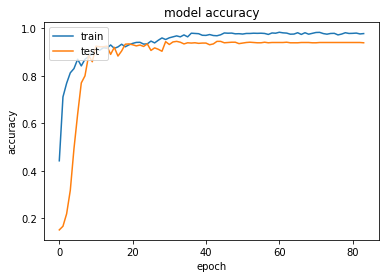

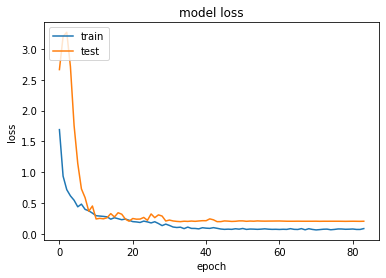

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 303us/sample - loss: 0.0173 - acc: 0.9908


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.08%
Accuracy on test set: 94.52%


In [20]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

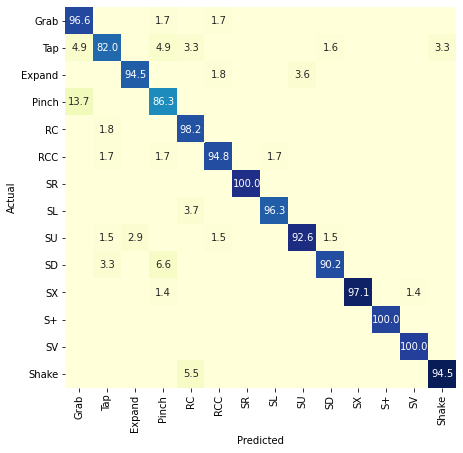

In [21]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [22]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

E:\Skelnet2D\SHREC\utils.py:83: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


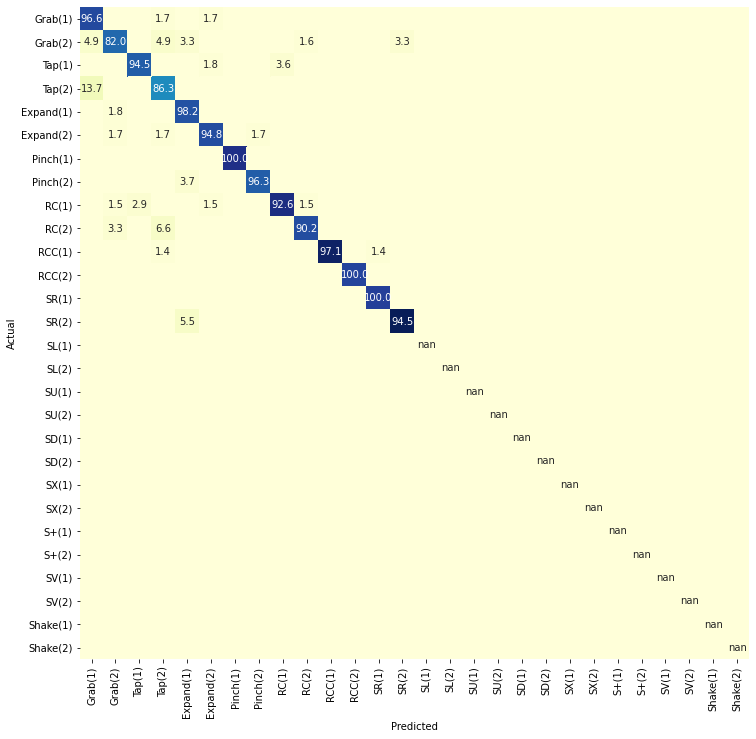

In [23]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))